In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
import sklearn.neural_network

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [3]:
import theano
import theano.tensor as T

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='latin-1')
f.close()

In [50]:
train_set[0][train_set[0]>=0.5]=1
train_set[0][train_set[0]<0.5]=0

In [51]:
valid_set[0][valid_set[0]>=0.5]=1
valid_set[0][valid_set[0]<0.5]=0

In [52]:
test_set[0][test_set[0]>=0.5]=1
test_set[0][test_set[0]<0.5]=0

In [53]:
x_train=theano.function([], T.concatenate([train_set[0], valid_set[0]]))()

In [54]:
x_test = theano.function([], theano.shared(test_set[0]))()

In [55]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = x_train.shape[1] # the dimension of x's feature space
batch_size = 100
n_epochs = 10000

In [56]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [57]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))


In [58]:
# Gaussian Encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [59]:
# Bernoulli MLP weights and biases (decoder)
bernoulli_b1 = init_w((n_hidden, ))
bernoulli_b2 = init_w((n_input, ))

bernoulli_W1 = init_w((n_latent, n_hidden))
bernoulli_W2 = init_w((n_hidden, n_input))

In [60]:
# Bernoulli Decoder
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, bernoulli_W1) + bernoulli_b1)
y = T.nnet.sigmoid(T.dot(h_decoder, bernoulli_W2) + bernoulli_b2)
log_likelihood = -T.nnet.binary_crossentropy(y, x).sum(axis = 1)


In [61]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, bernoulli_W1, bernoulli_W2]
b = [b3, b1, b2, bernoulli_b1, bernoulli_b2]
params = W + b

In [ ]:
'''ignore this cell'''
# from tadacof github
# Lower bound  # I think his original is wrong
# no neg sign for lower bound but cost should be -lower bound
lower_bound = -(DKL + log_likelihood).mean()
# weight decay 
L2 = sum([(w**2).sum() for w in W])
cost = lower_bound + batch_size/50000.0/2.0*L2


In [62]:
# Our lb and cost
lower_bound = (DKL + log_likelihood).mean()
cost = -lower_bound

In [63]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [117]:
updates = adagrad(cost, params, lr=0.02)

In [65]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              
eval_model = theano.function(inputs=[x, std_normal], outputs=lower_bound,
                             mode='FAST_RUN',
                             allow_input_downcast=True) 

In [66]:
training = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training.append(train_cost)
    #validation.append(val_cost)    

In [71]:
lb=[-i for i in training]

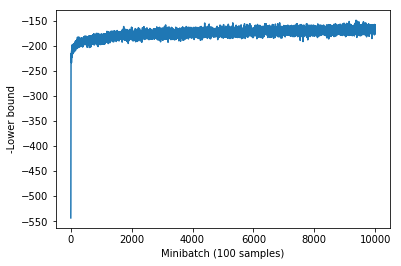

In [73]:
plt.ylabel("-Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(lb)

In [122]:
updates = adagrad(cost, params, lr=0.02)

In [123]:
train_model_likelihood = theano.function(inputs=[x, std_normal], 
                              outputs=log_likelihood.mean(), 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [124]:
training_likelihood = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    likelihood = train_model_likelihood(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_likelihood.append(likelihood)
    #validation.append(val_cost)    

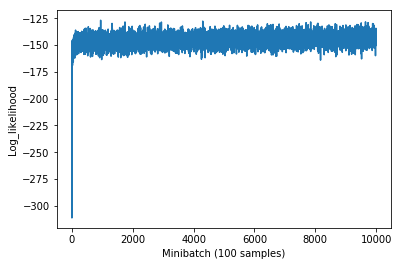

In [127]:
plt.ylabel("Log_likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood)

In [84]:
grads = T.grad(cost=cost, wrt=params)
grads

[dot.0,
 dot.0,
 dot.0,
 dot.0,
 dot.0,
 InplaceDimShuffle{1}.0,
 InplaceDimShuffle{1}.0,
 InplaceDimShuffle{1}.0,
 InplaceDimShuffle{1}.0,
 InplaceDimShuffle{1}.0]

In [92]:
len(params)

10

In [90]:
for p, g in zip(params, grads):
    print(p.get_value().shape)
    print(g)

(784, 100)
dot.0
(100, 2)
dot.0
(100, 2)
dot.0
(2, 100)
dot.0
(100, 784)
dot.0
(100,)
InplaceDimShuffle{1}.0
(2,)
InplaceDimShuffle{1}.0
(2,)
InplaceDimShuffle{1}.0
(100,)
InplaceDimShuffle{1}.0
(784,)
InplaceDimShuffle{1}.0


In [128]:
acc = theano.shared(params[0].get_value() * 0.)
acc.get_value().shape
acc_new = acc + grads[0] ** 2
acc_new

Elemwise{add,no_inplace}.0

In [146]:
seew3=updates[1][0].get_value()
seew3[seew3!=0]

array([-0.02807283,  0.01640856,  0.00507335, ..., -0.01829925,
        0.00607894, -0.00763082])

In [83]:
len(updates)

20

In [111]:
updates[2][0].get_value().shape

(100, 2)

In [82]:
updates[0][0].get_value()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
'''gaussian decoder and freyface starts next:'''

In [4]:
from scipy.io import loadmat
ff = loadmat('frey_rawface.mat', squeeze_me=True, struct_as_record=False)
ff1 = ff["ff"].T

In [5]:
f_train=ff1[:1500,]
f_test=ff1[1501:,]

In [161]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = f_train.shape[1] # the dimension of f's feature space
batch_size = 100
n_epochs = 100000

In [8]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [9]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))

In [10]:
#Gaussian encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [11]:
# Parameters
# Gaussian MLP weights and biases (decoder)
#initialize \theta

b6 = init_w((n_hidden, ))
b5 = init_w((n_input, ))
b4 = init_w((n_input, ))


W6 = init_w((n_latent, n_hidden))
W5 = init_w((n_hidden, n_input))
W4 = init_w((n_hidden, n_input))

In [35]:
-0.5*(f_train.shape[1]*np.log(2*np.pi))

-514.6055785946166

In [37]:
(log_sig2_prime).sum(axis=1)
-0.5*(log_sig2_prime.sum(axis=0))

Sum{axis=[1], acc_dtype=float64}.0

In [73]:
seemu=np.ones([1,560])
seelog_sig2=np.ones([1,560])
(-0.5*(f_train.shape[1]*np.log(2*np.pi))+(-0.5*(seelog_sig2.sum(axis=0)))+((-0.5*(f_train-seemu)**2/(np.exp(seelog_sig2))).sum(axis=0))).shape

(560,)

In [74]:
(-0.5*(seelog_sig2.sum(axis=0))).shape

(560,)

In [ ]:
-0.5*(f_train-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1).mean()

In [59]:
-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1).mean()

Elemwise{true_div,no_inplace}.0

In [ ]:
log_likelihood_gaus=(-0.5*(x.shape[1]*np.log(2*np.pi)))+(-0.5*(log_sig2_prime.sum(axis=0)))+((-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime))).sum(axis=0))


In [162]:
# Gaussian Decoder               --- ours!!!
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, W6) + b6)
mu_prime = T.dot(h_decoder, W4) + b4
log_sig2_prime = T.dot(h_decoder, W5) + b5

#log_likelihood_gaus=-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=0)
#log_likelihood_gaus=-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*sum(log_sig2_prime)-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1)
#log_likelihood_gaus=(-0.5*(x.shape[1]*np.log(2*np.pi)))+(-0.5*(log_sig2_prime.sum(axis=0)))+((-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime))).sum(axis=0))


In [163]:
log_likelihood_gaus= (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sig2_prime) - 0.5 * ((x - mu_prime)**2 / T.exp(log_sig2_prime))).sum(axis=1).mean(axis=0)

In [164]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, W6, W4, W5]
b = [b3, b1, b2, b6, b5, b4]
params = W + b

In [165]:
# Our lb and cost
lower_bound = (DKL + log_likelihood_gaus).mean()
#lower_bound=DKL.mean()
cost = -lower_bound

In [166]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [167]:
updates = adagrad(cost, params, lr=0.02)

In [168]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              
eval_model = theano.function(inputs=[x, std_normal], outputs=lower_bound,
                             mode='FAST_RUN',
                             allow_input_downcast=True) 

In [169]:
training = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ f_train[j] for j in np.random.randint(0,f_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training.append(train_cost)
    #validation.append(val_cost)    

In [170]:
lb=[-i for i in training]

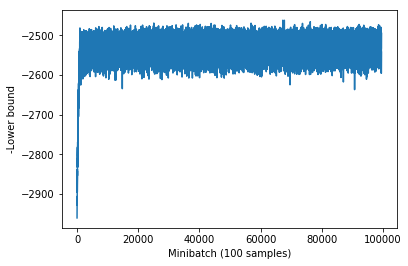

In [175]:
plt.ylabel("-Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(lb[500:])

In [176]:
updates = adagrad(cost, params, lr=0.02)

In [177]:
train_model_likelihood = theano.function(inputs=[x, std_normal], 
                              outputs=log_likelihood_gaus, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [178]:
training_likelihood = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ f_train[j] for j in np.random.randint(0,f_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    likelihood = train_model_likelihood(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_likelihood.append(likelihood)
    #validation.append(val_cost)    

In [189]:
training_likelihood[5000]

array(-7062.45089469)

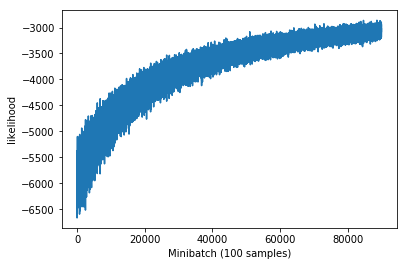

In [192]:
plt.ylabel("likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood[10000:])

In [ ]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [ ]:
def sgd(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append((p, p - lr * g))
    return updates

In [ ]:
def sgd_momentum(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):  #no bias correction
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc= beta*v + (1-beta)*g
        updates.append((v,vc))
        updates.append((p, p - lr * vc))
    return updates

In [ ]:
def adam(cost, params, lr=0.001, epsilon=1e-6):  #no bias correction, T.sqrt if **0.5 not work
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        m=theano.shared(p.get_value()* 0.)
        v=theano.shared(p.get_value()* 0.)
        mc = beta1*m + (1-beta1)*grad(x)
        vc = beta2*v + (1-beta2)*grad(x)**2
        updates.append((m,mc))
        updates.append((v,vc))
        updates.append((p, p - lr * mc/(epsilon+vc**0.5)))
    return updates

In [ ]:
def RMSprop(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc = beta*v + (1-beta)*g**2
        updates.append((v,vc))
        updates.append((p, p - lr * g/(epsilon+vc**(0.5))))
    return updates

In [ ]:
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, W6) + b6)
mu_prime = T.dot(h_decoder, W4) + b4
log_sig2_prime = T.dot(h_decoder, W5) + b5

In [35]:
T.sum(log_sig2_prime)

Sum{acc_dtype=float64}.0

In [33]:
log_sig2_prime.sum(axis=1)

Sum{axis=[1], acc_dtype=float64}.0

In [37]:
# our logpxz

-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*(log_sig2_prime.sum(axis=1))-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1)

Elemwise{sub,no_inplace}.0

In [40]:
#from VAE github:y0st
# had to change axis=2 to 1,  SOOO unreliable this guy!!  I would use ours!
logpxz = (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sig2_prime) - 0.5 * ((x - mu_prime)**2 / T.exp(log_sig2_prime))).sum(axis=1).mean(axis=0)
logpxz

mean